## This notebook is for plotting violin plots of the total sediment basket weights a GSD 

Importing the data:

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# load data
spring = pd.read_csv('spring2023_GSD.csv')
summer = pd.read_csv('summer2023_GSD.csv')

In [3]:
# Melt your DataFrame to long format
df_melted = spring.melt(id_vars='Size', var_name='Sample', value_name='Percentage')
# Create a new DataFrame for total weights
weights = spring[spring['Size'].isin(['WEIGHT'])].melt(id_vars='Size', var_name='Sample', value_name='Weight')
# Merge the two DataFrames
df_final = pd.merge(df_melted, weights, on='Sample')

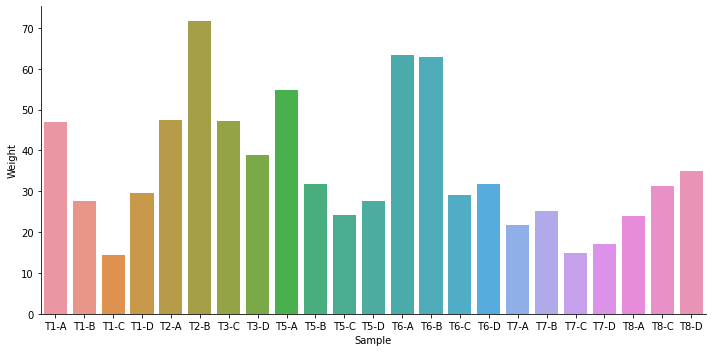

In [4]:
# simple bar plot of the data
sns.catplot(data=weights, x='Sample', y='Weight', kind='bar', height=5, aspect=2)
plt.show()

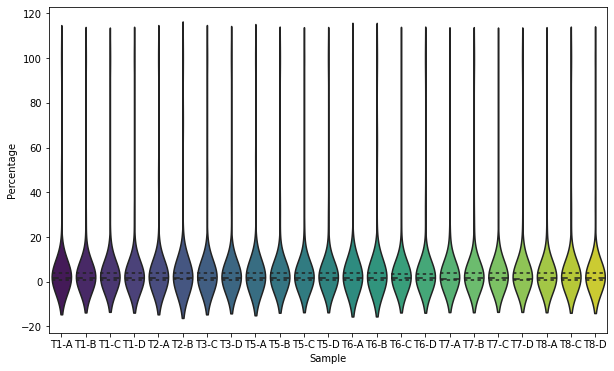

In [5]:

# Create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Sample', y='Percentage', data=df_final, scale='width', inner='quart', split=True, linewidth=1.5, palette='viridis')

# Adjust y limit to total weight of the samples
#plt.ylim(0, df_final['Weight'].max())


plt.show()

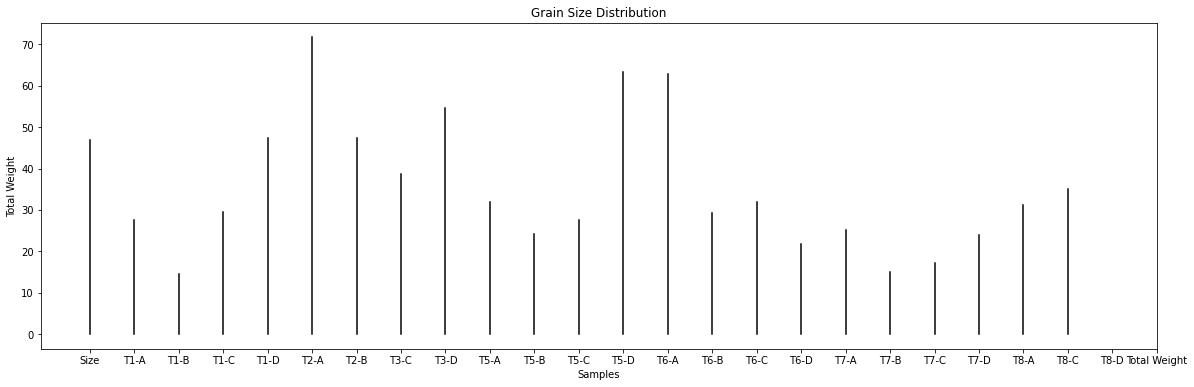

In [16]:
df = spring

# Extract grain size distribution
grain_sizes = df.iloc[:-2]

# Set up plot
fig, ax = plt.subplots(figsize=(20, 6))

# Plot vertical lines
for i, weight in enumerate(weights['Weight']):
    ax.plot([i, i], [0, weight], color='black')

# Set labels and title
ax.set_xlabel('Samples')
ax.set_ylabel('Total Weight')
ax.set_title('Grain Size Distribution')

# Set x-axis ticks and labels
ax.set_xticks(range(len(grain_sizes.columns)))
ax.set_xticklabels(grain_sizes.columns)

plt.show()

<AxesSubplot: xlabel='day', ylabel='total_bill'>

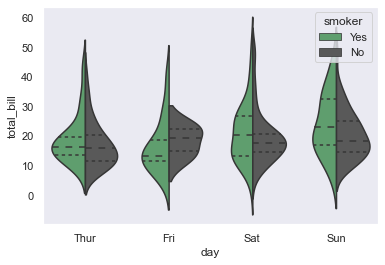

In [17]:
import seaborn as sns
sns.set_theme(style="dark")

# Load the example tips dataset
tips = sns.load_dataset("tips")

# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(data=tips, x="day", y="total_bill", hue="smoker",
               split=True, inner="quart", fill=False,
               palette={"Yes": "g", "No": ".35"})